## 1. importing packages

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras import optimizers

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## 2. overall configurations

In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

## 3. Getting the Data

In [3]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 2)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11
bova11_copy = bova11.copy()

In [4]:
len(bova11)

3497

## 4. Pre-processing

Adjust the columns name and type

In [5]:
bova11.columns = bova11.columns.str.lower()

In [6]:
bova11.date = pd.to_datetime(bova11.date)

In [7]:
bova11.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

Removing rows with volume 0

In [8]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11

,date,open,high,low,close,volume,dividends,stock splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3399,2023-01-27 00:00:00-03:00,110.279999,110.290001,108.339996,108.400002,5294651,0,0
3400,2023-01-30 00:00:00-03:00,109.010002,109.320000,108.129997,108.699997,2905618,0,0
3401,2023-01-31 00:00:00-03:00,108.709999,109.959999,108.709999,109.839996,5733562,0,0
3402,2023-02-01 00:00:00-03:00,109.489998,109.860001,107.059998,108.400002,10380157,0,0


Sorting the data by date

In [9]:
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

Adding a column with the previous close value

In [10]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [11]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999


Adding the close difference between dates

In [12]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3404/3404 [00:00<00:00, 6226.57it/s]


In [13]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close,close_change
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN,0.000000
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000,1.680000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000,0.320000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000,-1.680000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999,1.560001


Checking the dataseries over time

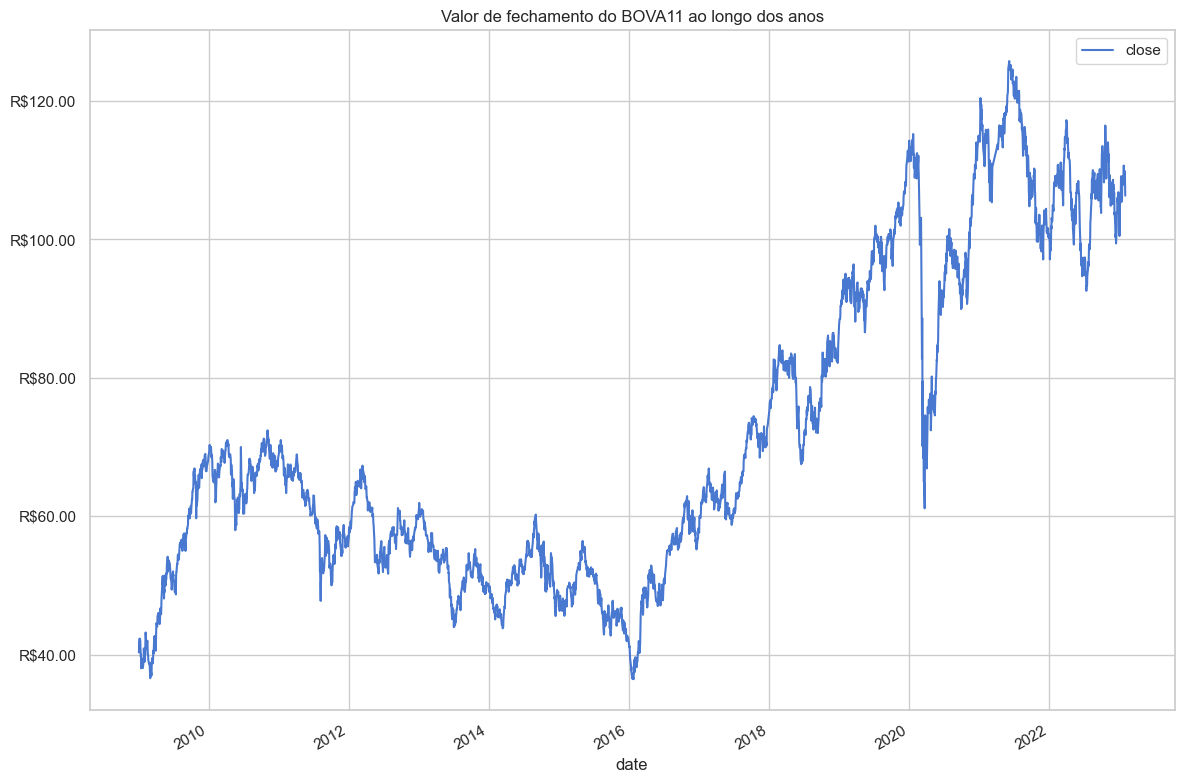

In [14]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

#### Feature Engineering
Add auxiliar columns that can improve our model, like moving averages,standard deviation, techinical indicators and others
Let's add:
- Moving_average for 3, 10, 30 and 60 days
- Standard deviation for 7, 30 and 60 days
- Bollinger limits for Upper and lowers 3, 30 and 60
- Add RSI indicator

In [15]:
# Adding move Averages columns
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()
bova11['ma_60d'] = bova11['close'].rolling(60, center = True, min_periods = 1).mean()

In [16]:
# Adding standard deviation columns
bova11['std_7'] = bova11['close'].rolling(7, center = True, min_periods = 1).std()
bova11['std_30'] = bova11['close'].rolling(30, center = True, min_periods = 1).std()
bova11['std_60'] = bova11['close'].rolling(60, center = True, min_periods = 1).std()

In [17]:
# Adding the bollinger bands
bova11['upper3'] = bova11['ma_3d'] + 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()
bova11['lower3'] = bova11['ma_3d'] - 2*bova11['close'].rolling(3, center = True, min_periods = 1).std()

bova11['upper30'] = bova11['ma_30d'] + 2*bova11['std_30']
bova11['lower30'] = bova11['ma_30d'] - 2*bova11['std_30']

bova11['upper60'] = bova11['ma_60d'] + 2*bova11['std_60']
bova11['lower60'] = bova11['ma_60d'] - 2*bova11['std_60']

In [18]:
# Adding tecnical indicator RSI
bova11['RSI'] = ta.rsi(bova11['close'], length = 15)

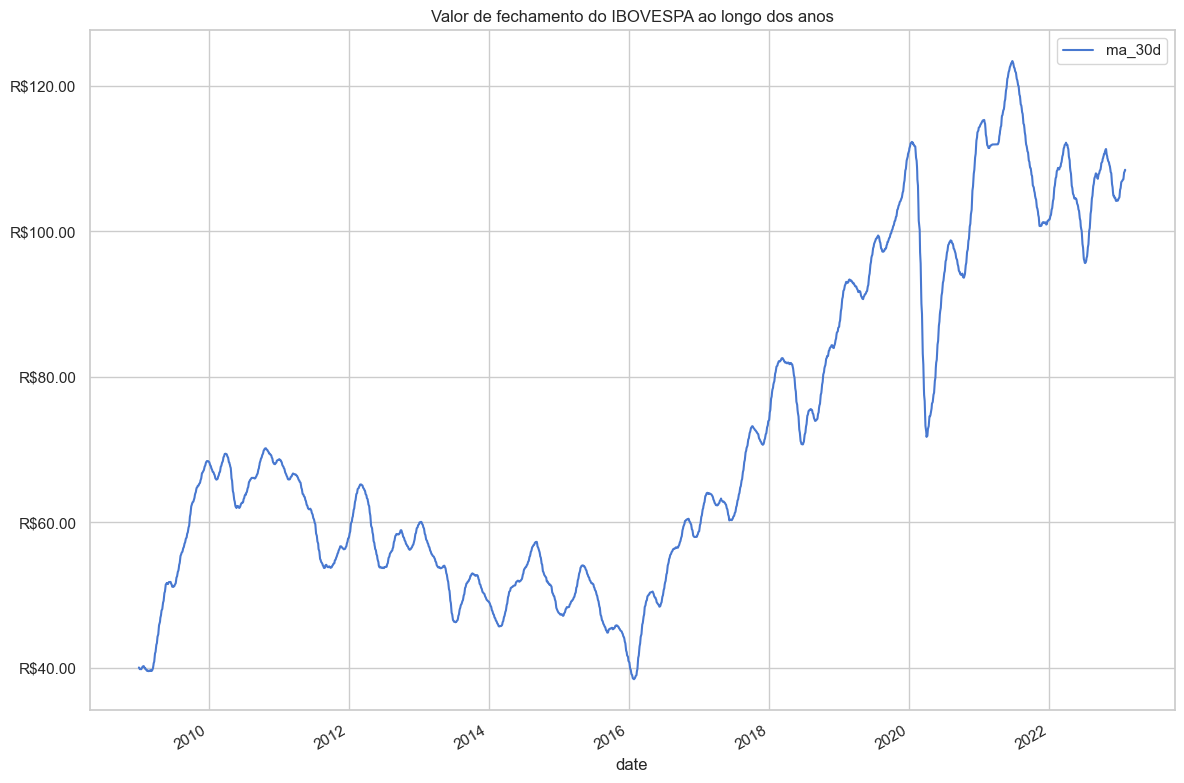

In [19]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

Select the features and the predict columns

In [20]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [21]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,std_30,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,1.459904,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,1.495795,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,1.466439,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,1.438465,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,1.418844,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,110.279999,110.290001,108.339996,108.400002,-2.019997,109.173332,108.849000,108.097000,106.076000,0.938720,1.546823,3.006460,111.353361,106.993303,111.190647,105.003353,112.088921,100.063079,53.755845
3400,109.010002,109.320000,108.129997,108.699997,0.299995,108.979998,108.893333,108.233684,106.240000,1.501802,1.459856,2.888394,110.499468,107.460529,111.153396,105.313973,112.016789,100.463212,54.525609
3401,108.709999,109.959999,108.709999,109.839996,1.139999,108.979998,109.017500,108.393889,106.447273,1.427915,1.319171,2.664053,110.499468,107.460529,111.032230,105.755548,111.775380,101.119166,57.411912
3402,109.489998,109.860001,107.059998,108.400002,-1.439995,108.180000,108.958571,108.465294,106.605938,1.279419,1.323428,2.543337,111.740443,104.619557,111.112150,105.818438,111.692613,101.519263,52.870335


In [22]:
bova11['target'] = bova11.close - bova11.open
#bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [23]:
bova11

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,ma_60d,std_7,...,std_60,upper3,lower3,upper30,lower30,upper60,lower60,RSI,target,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,40.216334,0.987387,...,1.394817,43.535879,38.784121,42.992476,37.152858,43.005967,37.426700,NaN,2.040001,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,40.269033,0.941319,...,1.402411,43.695279,39.398054,42.939715,36.956536,43.073854,37.464211,NaN,1.799999,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,40.322813,0.866718,...,1.412751,43.437411,39.869255,42.825231,36.959475,43.148315,37.497311,NaN,0.259998,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,40.313031,1.063445,...,1.391637,43.594461,39.845539,42.719153,36.965292,43.096304,37.529757,NaN,-1.110001,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,40.303530,1.118613,...,1.371508,43.311019,39.915647,42.735582,37.060208,43.046547,37.560513,NaN,2.049999,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,110.279999,110.290001,108.339996,108.400002,-2.019997,109.173332,108.849000,108.097000,106.076000,0.938720,...,3.006460,111.353361,106.993303,111.190647,105.003353,112.088921,100.063079,53.755845,-1.879997,108.699997
3400,109.010002,109.320000,108.129997,108.699997,0.299995,108.979998,108.893333,108.233684,106.240000,1.501802,...,2.888394,110.499468,107.460529,111.153396,105.313973,112.016789,100.463212,54.525609,-0.310005,109.839996
3401,108.709999,109.959999,108.709999,109.839996,1.139999,108.979998,109.017500,108.393889,106.447273,1.427915,...,2.664053,110.499468,107.460529,111.032230,105.755548,111.775380,101.119166,57.411912,1.129997,108.400002
3402,109.489998,109.860001,107.059998,108.400002,-1.439995,108.180000,108.958571,108.465294,106.605938,1.279419,...,2.543337,111.740443,104.619557,111.112150,105.818438,111.692613,101.519263,52.870335,-1.089996,106.300003


In [24]:
bova11.dropna(inplace = True)

In [25]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.41052802 -0.95937954 -0.97594966 ... -0.34158244 -0.812735
  -0.94288915]
 [-0.39380423 -0.93549828 -0.95100022 ... -0.1145866  -0.81635782
  -0.94311308]
 [-0.38663696 -0.9468809  -0.94178467 ... -0.11645738 -0.82917641
  -0.90033593]
 ...
 [ 0.73624277  0.62280992  0.62733194 ...  0.1831316  -0.85119142
   0.64367293]
 [ 0.73146451  0.63709403  0.64036862 ...  0.26982232 -0.81106316
   0.6114222 ]
 [ 0.74388784  0.63486217  0.6032816  ...  0.13341511 -0.87292727
   0.56438976]]


Select the features and prediction target columns

In [26]:
backcandles = 100
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

X.shape, y.shape

((3288, 100, 19), (3288, 1))

Split the train and test data

In [27]:
splitlimit = int(len(X) * 0.9)
X_train, X_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

In [28]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2959, 100, 19) (328, 100, 19) (2959, 1) (328, 1)


### 4. Creating the model

In [29]:
def create_lstm_model(backcandles, num_features, dropout_prob):
    model = Sequential()
    model.add(LSTM(64, input_shape = (backcandles, num_features)))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss = 'mse')
    return model

In [30]:
model = create_lstm_model(100, 19, 0.1)
model.fit(x = X_train, y = y_train, batch_size = 16, epochs = 10, shuffle = True, validation_split = 0.1)

Epoch 1/10
167/167 [==============================] - 19s 78ms/step - loss: 0.0075 - val_loss: 0.0015
Epoch 2/10
167/167 [==============================] - 12s 69ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 3/10
167/167 [==============================] - 12s 72ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 4/10
167/167 [==============================] - 12s 71ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 5/10
167/167 [==============================] - 12s 74ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 6/10
167/167 [==============================] - 13s 75ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/10
167/167 [==============================] - 13s 76ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/10
167/167 [==============================] - 12s 72ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 9/10
167/167 [==============================] - 13s 76ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 10/10
167/167 [==============================] - 13s 76ms/step - loss: 0.001

In [31]:
results = model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 35ms/step - loss: 0.0016


### 5. Making predictions

In [32]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

11/11 [==============================] - 2s 34ms/step
[0.583194] [0.63023511]
[0.57736254] [0.62418815]
[0.58975756] [0.65218367]
[0.5865466] [0.64613655]
[0.59481144] [0.57558797]
[0.5811737] [0.57402023]
[0.5410006] [0.50503922]
[0.53228986] [0.47547596]
[0.492999] [0.52519603]
[0.47803453] [0.47368421]


In [33]:
y_pred.shape

(328, 1)

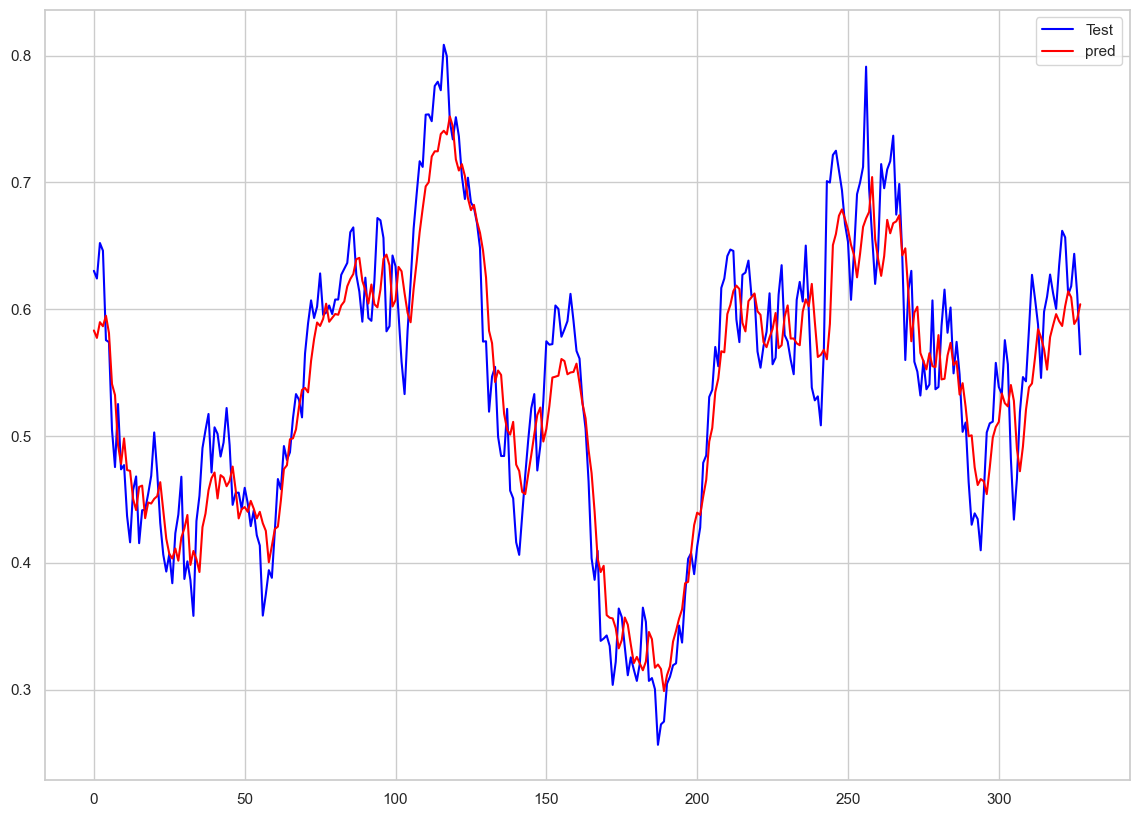

In [34]:
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

### 6. Calculating Error metrics

In [35]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [36]:
MAPE(y_test, y_pred)

6.28189136882774

In [37]:
MAE(y_test, y_pred)

0.033071512916580934

In [38]:
RMSE(y_test, y_pred)

0.040049689422201974

In [39]:
backcandles = 50
X = []
for j in range(19): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))
    
splitlimit = int(len(X) * 0.9)
x_train, x_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

### 7. Tuning the hyperparameters

In [40]:
def LSTM_hyperparameter_tuning(config):
    first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days = config
    combinations = list(itertools.product(first_add_layer, second_add_layer, third_add_layer,
                                         n_neurons, n_batch_size, dropout, pass_days))
    print(combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(combinations)):
        
        print(f'{i+1}th combination: \n')
        print('-'* 100)
        
        first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days = combinations[i]
        
        print(combinations[i])
        
        backcandles = pass_days
        X = []
        for j in range(19): # range is the number of feature columns you will use
            X.append([])
            for k in range(backcandles, bova11_scaled.shape[0]):
                X[j].append(bova11_scaled[k-backcandles:k, j])

        #move axis from 0 to position 2
        X = np.moveaxis(X, [0], [2])

        X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
        y = np.reshape(yi, (len(yi), 1))

        splitlimit = int(len(X) * 0.9)
        x_train, x_test = X[:splitlimit], X[splitlimit+1:]
        y_train, y_test = y[:splitlimit], y[splitlimit+1:]
        
        model = Sequential()
        model.add(LSTM(units = n_neurons, return_sequences = True,
                 input_shape = (x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(dropout))
        
        if first_add_layer:
            model.add(LSTM(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        if second_add_layer:
            model.add(LSTM(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        if third_add_layer:
            model.add(LSTM(units = n_neurons, return_sequences = True))
            model.add(Dropout(dropout))
        
        model.add(LSTM(units = n_neurons, return_sequences = False))
        model.add(Dropout(dropout))
        model.add(Dense(units = 1, activation = 'linear'))
        model.compile(optimizer = 'adam', 
                      loss = 'mse', 
                      metrics = [tf.keras.metrics.RootMeanSquaredError()])
        
        es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)
        
        file_path = 'best_model.h5'
        
        mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)
        
        model.fit(x_train, y_train, 
                  validation_split = 0.1, 
                  epochs = 50, 
                  batch_size = n_batch_size,
                  callbacks = [es, mc], 
                  verbose = 0,
                  shuffle = True)
        train_accuracy = model.evaluate(x_train, y_train, verbose = 0)
        test_accuracy = model.evaluate(x_test, y_test, verbose = 0)
        
        hist.append(list((first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout,pass_days, train_accuracy, test_accuracy)))
        
        print(f'{str(i)}-th combination = {combinations[i]} \n train accucary: {train_accuracy} and test accuracy: {test_accuracy}')
        print('-' * 100)
        print('-'* 100)
        
    return hist

In [41]:
config = [[False], [False], [False], [256, 128, 64], [32, 64], [0.2, 0.1], [50,100]]

hist = LSTM_hyperparameter_tuning(config)

[(False, False, False, 256, 32, 0.2, 50), (False, False, False, 256, 32, 0.2, 100), (False, False, False, 256, 32, 0.1, 50), (False, False, False, 256, 32, 0.1, 100), (False, False, False, 256, 64, 0.2, 50), (False, False, False, 256, 64, 0.2, 100), (False, False, False, 256, 64, 0.1, 50), (False, False, False, 256, 64, 0.1, 100), (False, False, False, 128, 32, 0.2, 50), (False, False, False, 128, 32, 0.2, 100), (False, False, False, 128, 32, 0.1, 50), (False, False, False, 128, 32, 0.1, 100), (False, False, False, 128, 64, 0.2, 50), (False, False, False, 128, 64, 0.2, 100), (False, False, False, 128, 64, 0.1, 50), (False, False, False, 128, 64, 0.1, 100), (False, False, False, 64, 32, 0.2, 50), (False, False, False, 64, 32, 0.2, 100), (False, False, False, 64, 32, 0.1, 50), (False, False, False, 64, 32, 0.1, 100), (False, False, False, 64, 64, 0.2, 50), (False, False, False, 64, 64, 0.2, 100), (False, False, False, 64, 64, 0.1, 50), (False, False, False, 64, 64, 0.1, 100)]


1th combi


Epoch 49: val_loss improved from 0.00093 to 0.00082, saving model to best_model.h5

Epoch 50: val_loss did not improve from 0.00082
2-th combination = (False, False, False, 256, 32, 0.1, 50) 
 train accucary: [0.0005007841973565519, 0.022378208115696907] and test accuracy: [0.0010951394215226173, 0.033092889934778214]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
4th combination: 

----------------------------------------------------------------------------------------------------
(False, False, False, 256, 32, 0.1, 100)

Epoch 1: val_loss improved from inf to 0.00189, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00189 to 0.00180, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.00180

Epoch 4: val_loss did not improve from 0.00180

Epoch 5: val_loss improved from 0.00180 to 0.00167, savin


Epoch 20: val_loss did not improve from 0.00139

Epoch 21: val_loss did not improve from 0.00139

Epoch 22: val_loss did not improve from 0.00139
Epoch 22: early stopping
6-th combination = (False, False, False, 256, 64, 0.1, 50) 
 train accucary: [0.0008282018825411797, 0.028778497129678726] and test accuracy: [0.0018538142321631312, 0.0430559441447258]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
8th combination: 

----------------------------------------------------------------------------------------------------
(False, False, False, 256, 64, 0.1, 100)

Epoch 1: val_loss improved from inf to 0.00283, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.00283

Epoch 3: val_loss improved from 0.00283 to 0.00188, saving model to best_model.h5

Epoch 4: val_loss improved from 0.00188 to 0.00187, saving model to 


Epoch 11: val_loss did not improve from 0.00149

Epoch 12: val_loss improved from 0.00149 to 0.00145, saving model to best_model.h5

Epoch 13: val_loss did not improve from 0.00145

Epoch 14: val_loss improved from 0.00145 to 0.00143, saving model to best_model.h5

Epoch 15: val_loss did not improve from 0.00143

Epoch 16: val_loss did not improve from 0.00143

Epoch 17: val_loss did not improve from 0.00143

Epoch 18: val_loss did not improve from 0.00143

Epoch 19: val_loss improved from 0.00143 to 0.00139, saving model to best_model.h5

Epoch 20: val_loss did not improve from 0.00139

Epoch 21: val_loss improved from 0.00139 to 0.00132, saving model to best_model.h5

Epoch 22: val_loss improved from 0.00132 to 0.00126, saving model to best_model.h5

Epoch 23: val_loss did not improve from 0.00126

Epoch 24: val_loss did not improve from 0.00126

Epoch 25: val_loss did not improve from 0.00126

Epoch 26: val_loss improved from 0.00126 to 0.00121, saving model to best_model.h5

Epoch


Epoch 25: val_loss did not improve from 0.00129

Epoch 26: val_loss did not improve from 0.00129

Epoch 27: val_loss did not improve from 0.00129

Epoch 28: val_loss did not improve from 0.00129

Epoch 29: val_loss improved from 0.00129 to 0.00125, saving model to best_model.h5

Epoch 30: val_loss did not improve from 0.00125

Epoch 31: val_loss did not improve from 0.00125

Epoch 32: val_loss did not improve from 0.00125

Epoch 33: val_loss did not improve from 0.00125

Epoch 34: val_loss did not improve from 0.00125

Epoch 35: val_loss did not improve from 0.00125

Epoch 36: val_loss did not improve from 0.00125
Epoch 36: early stopping
14-th combination = (False, False, False, 128, 64, 0.1, 50) 
 train accucary: [0.0010516189504414797, 0.03242867439985275] and test accuracy: [0.001822624122723937, 0.04269220307469368]
----------------------------------------------------------------------------------------------------
-----------------------------------------------------------------


Epoch 12: val_loss did not improve from 0.00173

Epoch 13: val_loss did not improve from 0.00173

Epoch 14: val_loss improved from 0.00173 to 0.00155, saving model to best_model.h5

Epoch 15: val_loss did not improve from 0.00155

Epoch 16: val_loss did not improve from 0.00155

Epoch 17: val_loss did not improve from 0.00155

Epoch 18: val_loss did not improve from 0.00155

Epoch 19: val_loss did not improve from 0.00155

Epoch 20: val_loss did not improve from 0.00155

Epoch 21: val_loss did not improve from 0.00155
Epoch 21: early stopping
18-th combination = (False, False, False, 64, 32, 0.1, 50) 
 train accucary: [0.0008965838351286948, 0.029943009838461876] and test accuracy: [0.0028003184124827385, 0.05291803553700447]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
20th combination: 

-----------------------------------------


Epoch 10: val_loss did not improve from 0.00208

Epoch 11: val_loss improved from 0.00208 to 0.00199, saving model to best_model.h5

Epoch 12: val_loss improved from 0.00199 to 0.00187, saving model to best_model.h5

Epoch 13: val_loss did not improve from 0.00187

Epoch 14: val_loss improved from 0.00187 to 0.00186, saving model to best_model.h5

Epoch 15: val_loss did not improve from 0.00186

Epoch 16: val_loss improved from 0.00186 to 0.00171, saving model to best_model.h5

Epoch 17: val_loss did not improve from 0.00171

Epoch 18: val_loss did not improve from 0.00171

Epoch 19: val_loss did not improve from 0.00171

Epoch 20: val_loss did not improve from 0.00171

Epoch 21: val_loss did not improve from 0.00171

Epoch 22: val_loss improved from 0.00171 to 0.00158, saving model to best_model.h5

Epoch 23: val_loss improved from 0.00158 to 0.00157, saving model to best_model.h5

Epoch 24: val_loss did not improve from 0.00157

Epoch 25: val_loss did not improve from 0.00157

Epoch

#### Choosing the Best Model

In [42]:
x_train.shape

(3004, 50, 19)

In [43]:
y_train.shape

(3004, 1)

In [44]:
y_train.shape

(3004, 1)

In [45]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by= [7], ascending = True)
hist

,0,1,2,3,4,5,6,7,8
2,False,False,False,256,32,0.1,50,"[0.0005007841973565519, 0.022378208115696907]","[0.0010951394215226173, 0.033092889934778214]"
1,False,False,False,256,32,0.2,100,"[0.000694441027007997, 0.026352249085903168]","[0.001518538105301559, 0.03896842524409294]"
23,False,False,False,64,64,0.1,100,"[0.0007621883414685726, 0.027607759460806847]","[0.0018667607801035047, 0.04320602864027023]"
11,False,False,False,128,32,0.1,100,"[0.0007833960116840899, 0.027989212423563004]","[0.0014183762250468135, 0.03766133636236191]"
5,False,False,False,256,64,0.2,100,"[0.000797417014837265, 0.028238574042916298]","[0.0019215260399505496, 0.04383521527051926]"
16,False,False,False,64,32,0.2,50,"[0.0008075158693827689, 0.028416823595762253]","[0.002096285345032811, 0.04578520730137825]"
6,False,False,False,256,64,0.1,50,"[0.0008282018825411797, 0.028778497129678726]","[0.0018538142321631312, 0.0430559441447258]"
10,False,False,False,128,32,0.1,50,"[0.000845606904476881, 0.029079321771860123]","[0.0018796160584315658, 0.04335453733801842]"
13,False,False,False,128,64,0.2,100,"[0.0008516605012118816, 0.029183223843574524]","[0.0019993295427411795, 0.044713862240314484]"
15,False,False,False,128,64,0.1,100,"[0.0008699871250428259, 0.029495544731616974]","[0.0021303740795701742, 0.04615597426891327]"


In [54]:
hist.to_csv('hist_lstm.csv', index = False)

In [46]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}\n pass_days = {hist.iloc[0,6]}')

print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -2], 4)[1]}\n')
print(f'{np.round((results - hist.iloc[0, -2][1])*100/np.round(results, 4))}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 256
 n_batch_size = 32
 dropout = 0.1
 pass_days = 50
Results Before Tunning:
 Test Set RMSE: 0.0016

Results After Tunning:
 Test Set RMSE: 0.0224

-1298.0% Improvement


In [47]:
hist.iloc[0, :-2]

0    False
1    False
2    False
3      256
4       32
5      0.1
6       50
Name: 2, dtype: object

In [48]:
first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days = list(hist.iloc[0, :-2])

In [49]:
print(first_add_layer, second_add_layer, third_add_layer, n_neurons, n_batch_size, dropout, pass_days)

False False False 256 32 0.1 50


In [50]:
x_train.shape

(3004, 50, 19)

In [51]:
model = Sequential()
model.add(LSTM(units = n_neurons, 
               return_sequences = True,
               input_shape = (x_train.shape[1],
                             x_train.shape[2])))
model.add(Dropout(dropout))

model.add(LSTM(units = n_neurons, return_sequences = False))
model.add(Dropout(dropout))
model.add(Dense(units = 1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 7)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)

model.fit(x_train, y_train, 
          validation_split = 0.1, 
          epochs = 50, batch_size = n_batch_size,
         callbacks = [es, mc], verbose = 0)


Epoch 1: val_loss improved from inf to 0.00226, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00226 to 0.00219, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00219 to 0.00189, saving model to best_model.h5

Epoch 4: val_loss improved from 0.00189 to 0.00161, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.00161

Epoch 6: val_loss did not improve from 0.00161

Epoch 7: val_loss did not improve from 0.00161

Epoch 8: val_loss improved from 0.00161 to 0.00137, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.00137

Epoch 10: val_loss did not improve from 0.00137

Epoch 11: val_loss improved from 0.00137 to 0.00125, saving model to best_model.h5

Epoch 12: val_loss did not improve from 0.00125

Epoch 13: val_loss did not improve from 0.00125

Epoch 14: val_loss did not improve from 0.00125

Epoch 15: val_loss did not improve from 0.00125

Epoch 16: val_loss did not improve from 0.00125

Epoch 17: val_loss

11/11 [==============================] - 8s 336ms/step


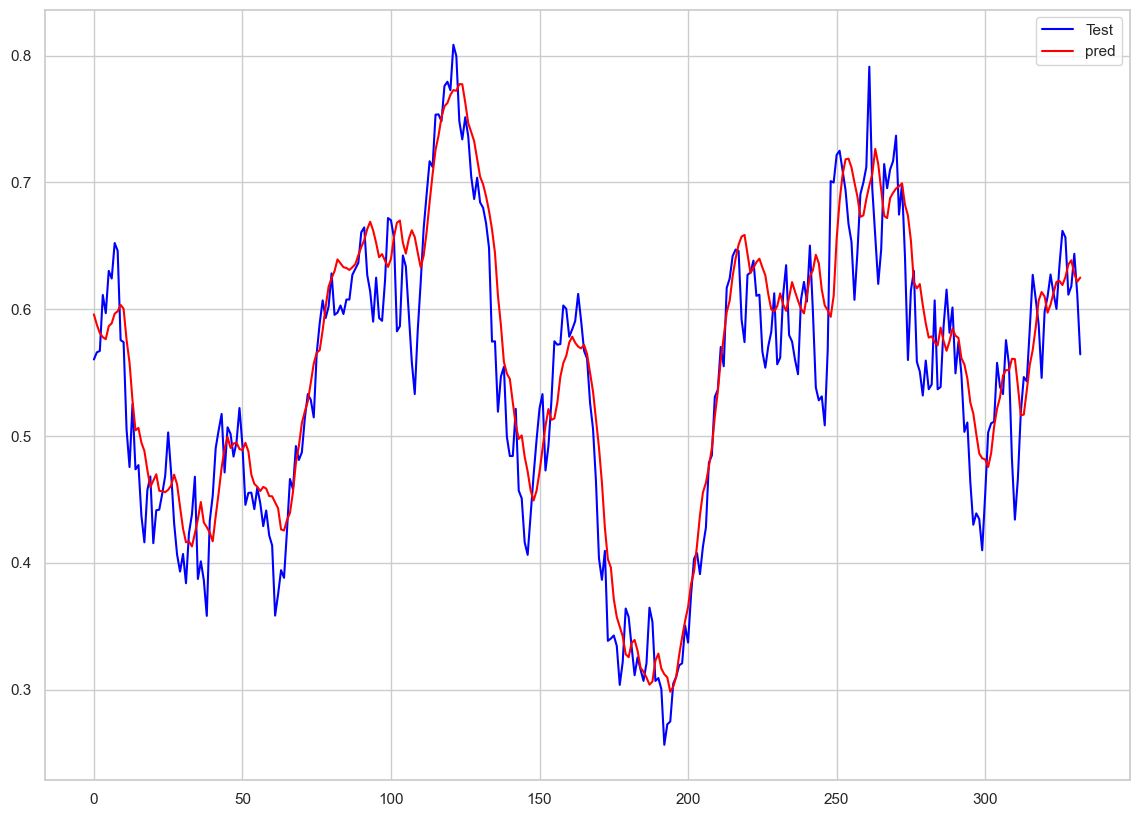

In [52]:
y_pred = model.predict(x_test)

plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [53]:
MAPE(y_test, y_pred), MAE(y_test, y_pred), RMSE(y_test, y_pred)

(6.517509997762148, 0.033325696566614306, 0.0419453111315337)